In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
twitter_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "twitter"]

In [7]:
twitter_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
3030,twitter,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031
3031,twitter,2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032
3032,twitter,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033
3033,twitter,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034
3034,twitter,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035
...,...,...,...,...,...,...,...,...,...
5208,twitter,2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209
5209,twitter,2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210
5210,twitter,2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211
5211,twitter,2022-07-11,34.599998,34.900002,32.549999,32.650002,32.650002,67071300,5212


In [8]:
end_date = twitter_price['date'].iloc[-1]
end_date

'2022-07-12'

In [9]:
twitter_price['date'] = pd.to_datetime(twitter_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
twitter_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
twitter_price.set_index("date",inplace = True)

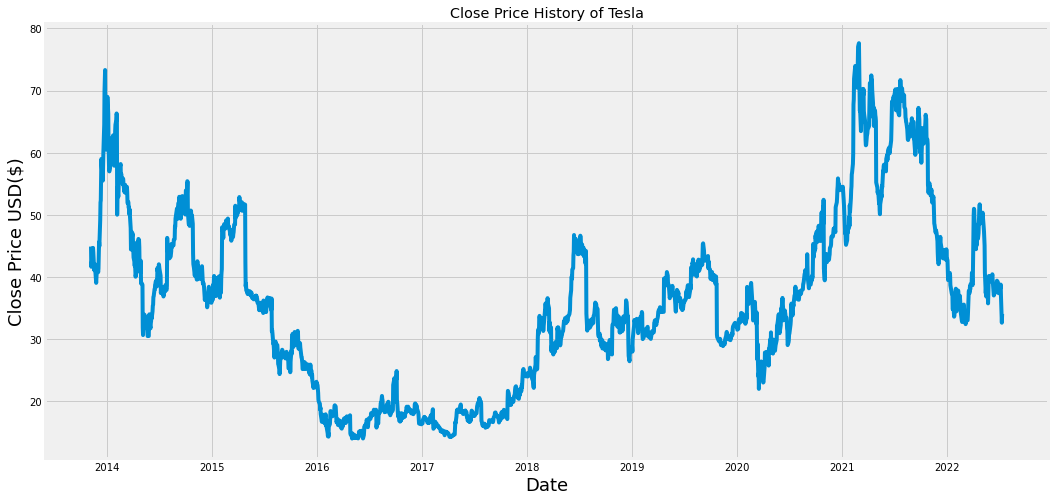

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(twitter_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = twitter_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((1747, 1), (436, 1))

In [17]:
train

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998
...,...
2020-10-09,45.900002
2020-10-12,48.250000
2020-10-13,47.000000


In [18]:
test

,close
date,
2020-10-16,45.810001
2020-10-19,45.820000
2020-10-20,46.349998
2020-10-21,50.240002
2020-10-22,50.279999
...,...
2022-07-06,38.209999
2022-07-07,38.790001
2022-07-08,36.810001


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.3583779 ],
       [0.29298967],
       [0.3151525 ]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1746, 1747)

In [21]:
train_scaled.shape,test_scaled.shape

((1747, 1), (436, 1))

In [22]:
train_scaled

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.51854765],
       [0.50251496],
       [0.50330086]])

In [23]:
test_scaled

array([[0.49984286],
       [0.50000002],
       [0.50833071],
       [0.56947507],
       [0.57010375],
       [0.57261868],
       [0.54998431],
       [0.58566491],
       [0.54259668],
       [0.60389817],
       [0.4298963 ],
       [0.40018865],
       [0.43571206],
       [0.45190191],
       [0.46683434],
       [0.45756052],
       [0.4586608 ],
       [0.44640052],
       [0.4655769 ],
       [0.45268787],
       [0.46321914],
       [0.45143039],
       [0.45331656],
       [0.46086142],
       [0.46541969],
       [0.48208113],
       [0.48616788],
       [0.49072621],
       [0.5095882 ],
       [0.51210314],
       [0.51084564],
       [0.51336057],
       [0.52216287],
       [0.53096515],
       [0.53002203],
       [0.53269418],
       [0.52530653],
       [0.52216287],
       [0.5847218 ],
       [0.58833701],
       [0.59745366],
       [0.61002832],
       [0.62904748],
       [0.63847851],
       [0.65796921],
       [0.63863566],
       [0.64287963],
       [0.633

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(1646, 100)
(1646,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(335, 100)
(335,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(1646, 100, 1)
(1646,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(335, 100, 1)
(335,)


(None, None)

In [31]:
X_test

array([[[0.49984286],
        [0.50000002],
        [0.50833071],
        ...,
        [0.8410877 ],
        [0.79880548],
        [0.85586296]],

       [[0.50000002],
        [0.50833071],
        [0.56947507],
        ...,
        [0.79880548],
        [0.85586296],
        [0.85020435]],

       [[0.50833071],
        [0.56947507],
        [0.57010375],
        ...,
        [0.85586296],
        [0.85020435],
        [0.88447032]],

       ...,

       [[0.36262187],
        [0.34313111],
        [0.34077334],
        ...,
        [0.38069791],
        [0.38305568],
        [0.38038353]],

       [[0.34313111],
        [0.34077334],
        [0.36105   ],
        ...,
        [0.38305568],
        [0.38038353],
        [0.38950019]],

       [[0.34077334],
        [0.36105   ],
        [0.34941847],
        ...,
        [0.38038353],
        [0.38950019],
        [0.3583779 ]]])

In [32]:
ytest

array([0.85020435, 0.88447032, 0.86828046, 0.88321282, 0.8285131 ,
       0.82081115, 0.80477839, 0.79000313, 0.75526569, 0.74174793,
       0.74269098, 0.76909779, 0.76988375, 0.77994347, 0.78308715,
       0.7895316 , 0.83291422, 0.86419366, 0.89924558, 0.89877404,
       0.89358698, 0.91857906, 0.87598241, 0.90694753, 0.88195545,
       0.84768948, 0.81248034, 0.8381013 , 0.79063188, 0.83322854,
       0.8285131 , 0.8173531 , 0.81248034, 0.80289215, 0.64775233,
       0.63769261, 0.63486331, 0.6216599 , 0.62558948, 0.62527512,
       0.59415283, 0.61097144, 0.57670548, 0.56743167, 0.59289534,
       0.60657026, 0.61584409, 0.61160012, 0.63973595, 0.63564921,
       0.67667405, 0.67573093, 0.68909148, 0.69270676, 0.69144926,
       0.68264698, 0.67824587, 0.67588809, 0.70716759, 0.71707015,
       0.70418112, 0.71832759, 0.7276014 , 0.73074508, 0.73593216,
       0.72650113, 0.72178564, 0.73404592, 0.73624647, 0.75369383,
       0.78230118, 0.82489784, 0.85256213, 0.84753226, 0.85319

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 100
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
52/52 [==============================] - 16s 126ms/step - loss: 0.0076
Epoch 2/100
52/52 [==============================] - 6s 115ms/step - loss: 0.0022
Epoch 3/100
52/52 [==============================] - 6s 120ms/step - loss: 0.0019
Epoch 4/100
52/52 [==============================] - 6s 116ms/step - loss: 0.0016
Epoch 5/100
52/52 [==============================] - 6s 122ms/step - loss: 0.0014
Epoch 6/100
52/52 [==============================] - 8s 156ms/step - loss: 0.0014
Epoch 7/100
52/52 [==============================] - 8s 158ms/step - loss: 0.0011
Epoch 8/100
52/52 [==============================] - 8s 160ms/step - loss: 0.0011
Epoch 9/100
52/52 [==============================] - 8s 152ms/step - loss: 9.7927e-04
Epoch 10/100
52/52 [==============================] - 11s 210ms/step - loss: 9.1203e-04
Epoch 11/100
52/52 [==============================] - 8s 148ms/step - loss: 8.5023e-04
Epoch 12/100
52/52 [==============================] - 9s 171ms/step - loss: 7.6698

52/52 [==============================] - 7s 127ms/step - loss: 3.1473e-04
Epoch 96/100
52/52 [==============================] - 7s 132ms/step - loss: 3.3831e-04
Epoch 97/100
52/52 [==============================] - 7s 132ms/step - loss: 3.1080e-04
Epoch 98/100
52/52 [==============================] - 7s 138ms/step - loss: 2.9930e-04
Epoch 99/100
52/52 [==============================] - 8s 146ms/step - loss: 3.5198e-04
Epoch 100/100
52/52 [==============================] - 7s 131ms/step - loss: 3.1067e-04


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 43ms/step


In [38]:
test_predict

array([[0.8333873 ],
       [0.780065  ],
       [0.84545964],
       [0.80124795],
       [0.8414597 ],
       [0.76515037],
       [0.7917867 ],
       [0.7567013 ],
       [0.7535821 ],
       [0.7132537 ],
       [0.71156913],
       [0.7083401 ],
       [0.7360239 ],
       [0.72621053],
       [0.74345154],
       [0.741172  ],
       [0.75111026],
       [0.7944915 ],
       [0.81274045],
       [0.84782463],
       [0.8383128 ],
       [0.8429703 ],
       [0.8683818 ],
       [0.8132662 ],
       [0.87235695],
       [0.8152242 ],
       [0.8065478 ],
       [0.76760405],
       [0.80636054],
       [0.7329778 ],
       [0.80967146],
       [0.76765484],
       [0.77730966],
       [0.76709807],
       [0.76058996],
       [0.58927435],
       [0.63961947],
       [0.60325444],
       [0.5983064 ],
       [0.6015644 ],
       [0.5993302 ],
       [0.5660817 ],
       [0.59401435],
       [0.5476436 ],
       [0.5513449 ],
       [0.57636404],
       [0.5859675 ],
       [0.596

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.016694405087651767

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.03540145202935989

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.026910520789108428

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.0431271757284238

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

4.31


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict

array([[67.0301  ],
       [63.637737],
       [67.79814 ],
       [64.98539 ],
       [67.54366 ],
       [62.68886 ],
       [64.38347 ],
       [62.151333],
       [61.952892],
       [59.387196],
       [59.280025],
       [59.074596],
       [60.83584 ],
       [60.21151 ],
       [61.308384],
       [61.16336 ],
       [61.79563 ],
       [64.55555 ],
       [65.716545],
       [67.9486  ],
       [67.34346 ],
       [67.63977 ],
       [69.25645 ],
       [65.75    ],
       [69.50935 ],
       [65.87456 ],
       [65.32257 ],
       [62.844967],
       [65.31066 ],
       [60.642044],
       [65.5213  ],
       [62.848198],
       [63.462437],
       [62.812775],
       [62.39873 ],
       [51.49963 ],
       [54.702587],
       [52.389046],
       [52.074253],
       [52.281525],
       [52.139385],
       [50.024117],
       [51.80119 ],
       [48.85108 ],
       [49.08656 ],
       [50.678276],
       [51.28925 ],
       [51.935993],
       [51.59981 ],
       [53.719727],


In [46]:
test_predict.shape

(335, 1)

In [47]:
targets = test[price_column][window_len+1:]
targets

date
2021-03-15    70.279999
2021-03-16    69.250000
2021-03-17    70.199997
2021-03-18    66.720001
2021-03-19    66.230003
                ...    
2022-07-06    38.209999
2022-07-07    38.790001
2022-07-08    36.810001
2022-07-11    32.650002
2022-07-12    34.060001
Name: close, Length: 335, dtype: float64

In [48]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2021-03-15    67.030098
2021-03-16    63.637737
2021-03-17    67.798141
2021-03-18    64.985390
2021-03-19    67.543663
                ...    
2022-07-06    38.168453
2022-07-07    38.339283
2022-07-08    38.188164
2022-07-11    38.760445
2022-07-12    36.769398
Length: 335, dtype: float32

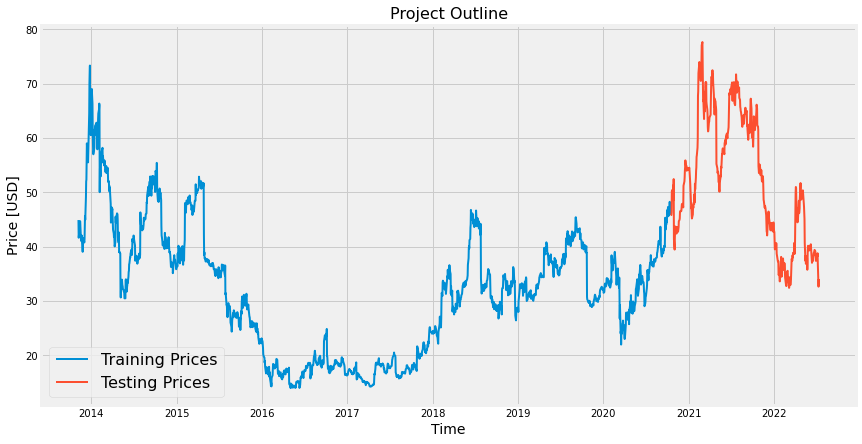

In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

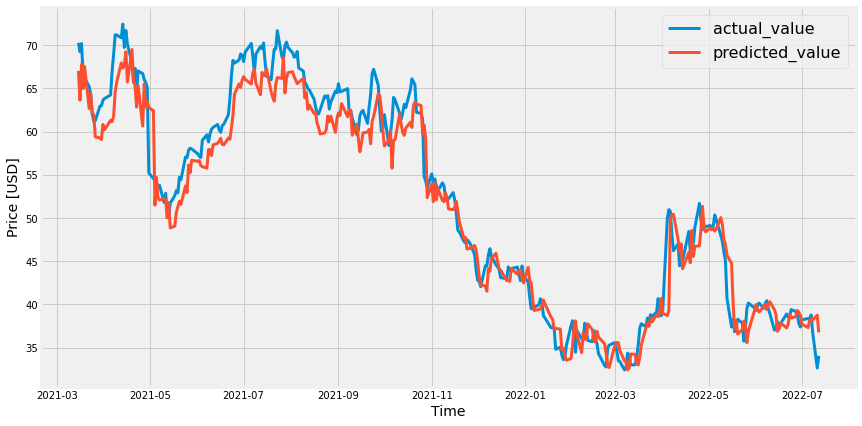

In [50]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [51]:
len(test)

436

In [52]:
length = len(test_scaled)
length

436

In [53]:
#Getting the last 100 days records
fut_inp = test_scaled[length-100:]
fut_inp.shape

(100, 1)

In [54]:
fut_inp = fut_inp.reshape(1,-1)

In [55]:
fut_inp.shape

(1, 100)

In [56]:
fut_inp

array([[0.34941847, 0.33668659, 0.31923925, 0.29739077, 0.29471862,
        0.32961334, 0.33448604, 0.33857278, 0.33872999, 0.32395473,
        0.30619307, 0.30462119, 0.28937439, 0.29346119, 0.32002515,
        0.31609557, 0.29849105, 0.29896259, 0.31373785, 0.33574348,
        0.36607985, 0.37346748, 0.36828042, 0.38384158, 0.3770827 ,
        0.38997173, 0.38651366, 0.39468721, 0.41936498, 0.39280102,
        0.38792833, 0.39767372, 0.5652311 , 0.5811066 , 0.57780575,
        0.53473751, 0.50644454, 0.5187048 , 0.47893746, 0.50047154,
        0.48836849, 0.54133924, 0.50534426, 0.51414653, 0.51980515,
        0.54888402, 0.59242381, 0.56067277, 0.54432569, 0.55171334,
        0.55029867, 0.55218486, 0.54794091, 0.55092742, 0.57136125,
        0.56255895, 0.53363723, 0.52263438, 0.50424397, 0.48836849,
        0.41983656, 0.3674945 , 0.38211256, 0.35900659, 0.3659227 ,
        0.38164103, 0.37488215, 0.34187361, 0.3638793 , 0.40097456,
        0.41119144, 0.40223199, 0.39751651, 0.40

In [57]:
tmp_inp = list(fut_inp)

In [58]:
tmp_inp

[array([0.34941847, 0.33668659, 0.31923925, 0.29739077, 0.29471862,
        0.32961334, 0.33448604, 0.33857278, 0.33872999, 0.32395473,
        0.30619307, 0.30462119, 0.28937439, 0.29346119, 0.32002515,
        0.31609557, 0.29849105, 0.29896259, 0.31373785, 0.33574348,
        0.36607985, 0.37346748, 0.36828042, 0.38384158, 0.3770827 ,
        0.38997173, 0.38651366, 0.39468721, 0.41936498, 0.39280102,
        0.38792833, 0.39767372, 0.5652311 , 0.5811066 , 0.57780575,
        0.53473751, 0.50644454, 0.5187048 , 0.47893746, 0.50047154,
        0.48836849, 0.54133924, 0.50534426, 0.51414653, 0.51980515,
        0.54888402, 0.59242381, 0.56067277, 0.54432569, 0.55171334,
        0.55029867, 0.55218486, 0.54794091, 0.55092742, 0.57136125,
        0.56255895, 0.53363723, 0.52263438, 0.50424397, 0.48836849,
        0.41983656, 0.3674945 , 0.38211256, 0.35900659, 0.3659227 ,
        0.38164103, 0.37488215, 0.34187361, 0.3638793 , 0.40097456,
        0.41119144, 0.40223199, 0.39751651, 0.40

In [59]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [60]:
tmp_inp

[0.34941846979338886,
 0.33668659242470567,
 0.3192392479993357,
 0.29739077164684546,
 0.29471862439729446,
 0.3296133446846907,
 0.33448604217947375,
 0.3385727761037146,
 0.33872999082348265,
 0.32395473077435066,
 0.30619306693774273,
 0.30462118695164353,
 0.28937439277150534,
 0.2934611895690594,
 0.3200251486965646,
 0.3160955666187786,
 0.2984910546286256,
 0.29896258875963155,
 0.31373784880876365,
 0.3357434770077087,
 0.3660798506482167,
 0.3734674806727828,
 0.3682804166117769,
 0.38384157735813773,
 0.37708269618434587,
 0.389971725399484,
 0.3865136617343756,
 0.39468720817449887,
 0.419364983622995,
 0.3928010244954899,
 0.3879283270007069,
 0.39767372199027284,
 0.5652311017870686,
 0.5811065976629957,
 0.5778057487176554,
 0.5347375134267923,
 0.5064445381850614,
 0.5187048028310972,
 0.4789374636405592,
 0.5004715419901701,
 0.4883684920639024,
 0.5413392427541296,
 0.5053442552032813,
 0.5141465347758504,
 0.5198051486861905,
 0.5488840246251504,
 0.5924238097653477,

In [61]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.31224364042282104], [0.31135129928588867], [0.31156256794929504], [0.31176987290382385], [0.31186312437057495], [0.31175926327705383], [0.31148403882980347], [0.31110599637031555], [0.3107011616230011], [0.31033211946487427], [0.3100389838218689], [0.30983880162239075], [0.30973020195961], [0.3096996545791626], [0.30972805619239807], [0.30979564785957336], [0.3098854422569275], [0.30998489260673523], [0.3100862503051758], [0.3101864755153656], [0.3102854788303375], [0.31038594245910645], [0.3104914724826813], [0.31060609221458435], [0.31073370575904846], [0.3108777403831482], [0.31104037165641785], [0.3112233579158783], [0.31142759323120117], [0.31165313720703125]]


In [62]:
end_date

'2022-07-12'

In [63]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [64]:
preds = scaler.inverse_transform(lst_output)
preds

array([[33.87493947],
       [33.81816873],
       [33.83160964],
       [33.84479838],
       [33.85073104],
       [33.84412339],
       [33.82661362],
       [33.80256256],
       [33.77680697],
       [33.75332851],
       [33.73467922],
       [33.72194363],
       [33.71503452],
       [33.7130911 ],
       [33.71489801],
       [33.71919819],
       [33.72491091],
       [33.73123794],
       [33.73768631],
       [33.74406264],
       [33.75036123],
       [33.75675273],
       [33.76346655],
       [33.77075865],
       [33.77887743],
       [33.78804091],
       [33.79838751],
       [33.8100291 ],
       [33.82302255],
       [33.83737165]])

In [65]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [66]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [67]:
len(c)

30

In [68]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12    33.874939
2022-07-13    33.818169
2022-07-14    33.831610
2022-07-15    33.844798
2022-07-18    33.850731
2022-07-19    33.844123
2022-07-20    33.826614
2022-07-21    33.802563
2022-07-22    33.776807
2022-07-25    33.753329
2022-07-26    33.734679
2022-07-27    33.721944
2022-07-28    33.715035
2022-07-29    33.713091
2022-08-01    33.714898
2022-08-02    33.719198
2022-08-03    33.724911
2022-08-04    33.731238
2022-08-05    33.737686
2022-08-08    33.744063
2022-08-09    33.750361
2022-08-10    33.756753
2022-08-11    33.763467
2022-08-12    33.770759
2022-08-15    33.778877
2022-08-16    33.788041
2022-08-17    33.798388
2022-08-18    33.810029
2022-08-19    33.823023
2022-08-22    33.837372
Freq: B, dtype: float64

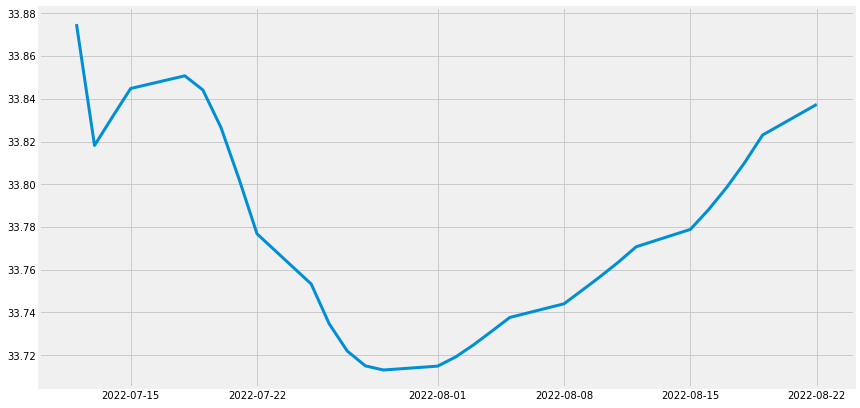

In [72]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

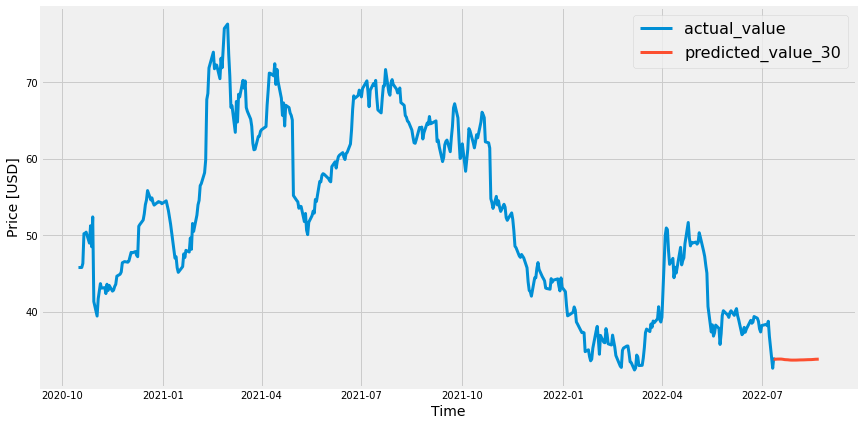

In [74]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)

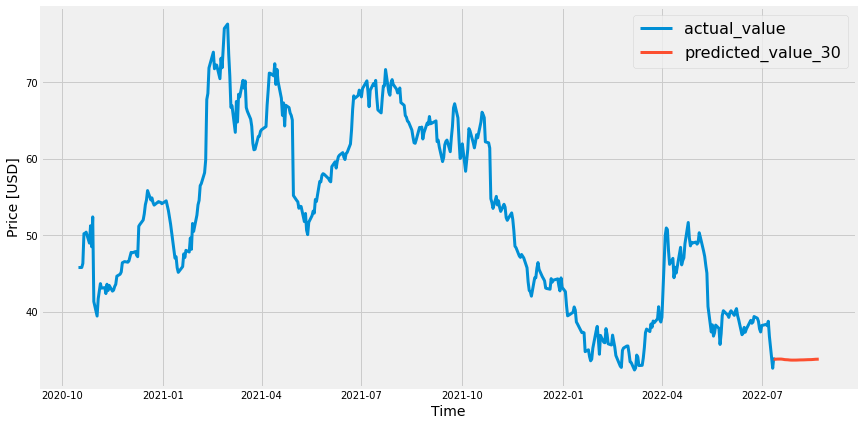

In [73]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)